##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 卷积变分自编码器

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/cvae">
    <img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />
    在 tensorFlow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/zh-cn/tutorials/generative/cvae.ipynb">
    <img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />
    在 Google Colab 中运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/zh-cn/tutorials/generative/cvae.ipynb">
    <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />
    在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/zh-cn/tutorials/generative/cvae.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://www.tensorflow.org/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

![训练过程中输出的演变](https://tensorflow.google.cn/images/autoencoders/cvae.gif)

本笔记演示了如何通过训练变分自编码器（[1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)）来生成手写数字图片。


In [2]:
# 用于生成 gif
!pip install -q imageio

## 导入 Tensorflow 与其他库

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version 仅应用于 Colab。
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

## 加载 MNIST 数据集

每个 MNIST 图片最初都是包含 784 个整数的向量，每个整数取值都在 0-255 之间，表示像素的强度。我们在模型中使用伯努利分布对每个像素进行建模，并对数据集进行静态二值化。

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# 标准化图片到区间 [0., 1.] 内
train_images /= 255.
test_images /= 255.

# 二值化
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [6]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

## 使用 *tf.data* 来将数据分批和打乱

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## 通过 *tf.keras.Sequential* 连接生成网络与推理网络


在我们的 VAE 示例中，我们将两个小型的 ConvNet 用于生成和推断网络。由于这些神经网络较小，我们使用 `tf.keras.Sequential` 来简化代码。在下面的描述中，令 $x$ 和 $z$ 分别表示观测值和潜在变量

### 生成网络


这里定义了生成模型，该模型将潜在编码作为输入，并输出用于观测条件分布的参数，即 $p(x|z)$。另外，我们对潜在变量使用单位高斯先验 $p(z)$。

### 推理网络


这里定义了近似后验分布 $q(z|x)$，该后验分布以观测值作为输入，并输出用于潜在表示的条件分布的一组参数。在本示例中，我们仅将此分布建模为对角高斯模型。在这种情况下，推断网络将输出因式分解的高斯均值和对数方差参数（为了数值稳定性使用对数方差而不是直接使用方差）。

### 重参数化技巧

在优化过程中，我们可以从 $q(z|x)$ 中采样，方法是首先从单位高斯采样，然后乘以标准偏差并加平均值。这样可以确保梯度能够通过样本传递到推理网络参数。

### 网络架构

对于推理网络，我们使用两个卷积层，后接一个全连接层。在生成网络中，我们通过使用全连接层，后接三个卷积转置层（在某些情况下也称为反卷积层）来镜像词体系结构。请注意，在训练 VAE 时避免使用批归一化（batch normalization）是一种常见的做法，因为使用小批量处理会导致额外的随机性，从而加剧随机抽样的不稳定性。

In [8]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

## 定义损失函数和优化器

VAE 通过最大化边际对数似然的证据下界（ELBO）进行训练：

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

实际上，我们优化了此期望的单样本蒙卡特罗估计：

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
其中 $z$ 从 $q(z|x)$ 中采样。

**注意**：我们也可以分析性地计算 KL 项，但简单起见，这里我们将所有三个项合并到蒙卡特罗估计器中。

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 训练

* 我们从迭代数据集开始
* 在每次迭代期间，我们将图像传递给编码器，以获得近似后验 $q(z|x)$ 的一组均值和对数方差参数
* 然后，我们应用 *重参数化技巧* 从 $q(z|x)$ 中采样
* 最后，我们将重新参数化的样本传递给解码器，以获取生成分布 $p(x|z)$ 的 logit
* **注意：**由于我们使用的是由 keras 加载的数据集，其中训练集中有 6 万个数据点，测试集中有 1 万个数据点，因此我们在测试集上的最终 ELBO 略高于对 Larochelle 版 MNIST 使用动态二值化的文献中的报告结果。

## 生成图片

* 进行训练后，可以生成一些图片了
* 我们首先从单位高斯先验分布 $p(z)$ 中采样一组潜在向量
* 随后生成器将潜在样本 $z$ 转换为观测值的 logit，得到分布 $p(x|z)$
* 这里我们画出伯努利分布的概率

In [10]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# 保持随机向量恒定以进行生成（预测），以便更易于看到改进。
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout 最小化两个子图之间的重叠
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Epoch: 100, Test set ELBO: -78.06732940673828, time elapse for current epoch 1.886899471282959


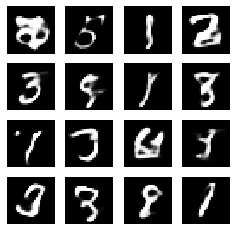

In [12]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

### 使用 epoch 编号显示图片

In [13]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

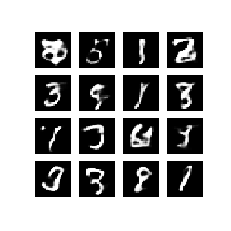

In [14]:
plt.imshow(display_image(epochs))
plt.axis('off')# 显示图片

### 生成所有保存图片的 GIF

In [15]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

如果您正使用 Colab，您可以使用以下代码下载动画。

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)